In [1]:
import tensorflow as tf


physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/#:~:text=In%20the%202014%20ImageNet%20Classification,present%20in%20our%20Food%20dataset.

In [1]:
import os
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras import layers, models, Model, optimizers
from PIL import ImageFile,Image

from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.applications.MobileNetV2 import MobileNetV2

import datetime
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
BATCH_SIZE = 64

train_generator =ImageDataGenerator( validation_split=0.15,
                                    #rescale=1./255,
                                   preprocessing_function=preprocess_input )

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # MobileNetV2

In [3]:
train_data_dir ='D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Training/'
test_data_dir = 'D:/TQ/Fruits360/fruits-360_dataset/fruits-360/Test/'

total_classes = sorted(os.listdir(train_data_dir))
print(total_classes)


['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [4]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(100, 100),
                                               class_mode='categorical',
                                               classes=total_classes,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(100, 100),
                                             class_mode=None,
                                             classes=total_classes,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 57612 images belonging to 131 classes.
Found 10080 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [5]:
# Model Creation
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=(100,100,3),
                   pooling='avg',classes=131,
                   weights='imagenet')
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
     
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(32,activation='relu')(top_model)
    top_model = Dense(16,activation='relu')(top_model)
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
# Use a smaller learning rate
input_shape = (100,100, 3)
#optim_1 = Adam(learning_rate=0.001)
n_classes=len(total_classes)

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 10

optim_2 = Adam(learning_rate=0.0001)

# First we'll train the model without Fine-tuning
mobile_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [7]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()
csv_logger = CSVLogger('D:/TQ/Fruits360/MobileNet_Model_July_26_FineTuned2.csv', separator=',')

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='D:/TQ/Fruits360/MobileNet_Model_July_26_FT_2.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [8]:
mobile_model_ft.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 50, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 50, 50, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 50, 50, 32)   0           ['bn_Conv1[0][0]']           

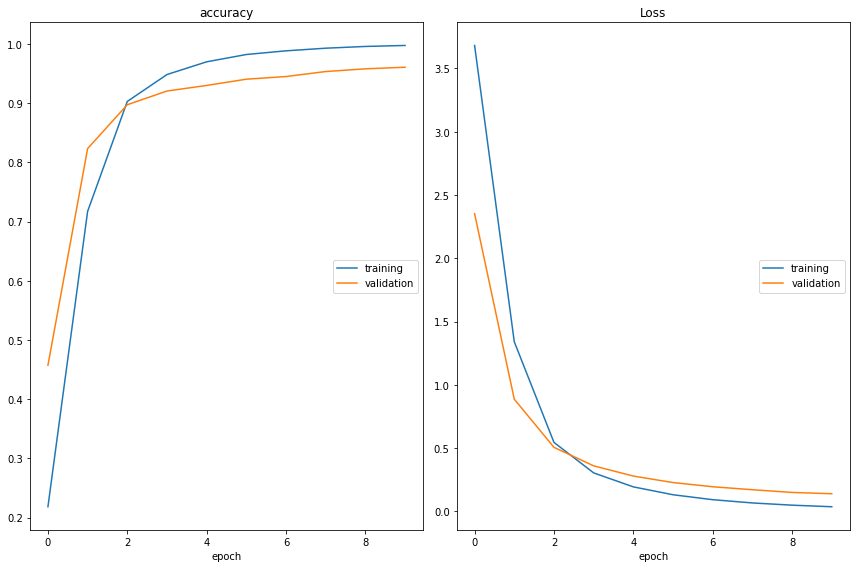

accuracy
	training         	 (min:    0.218, max:    0.998, cur:    0.998)
	validation       	 (min:    0.457, max:    0.961, cur:    0.961)
Loss
	training         	 (min:    0.037, max:    3.682, cur:    0.037)
	validation       	 (min:    0.139, max:    2.352, cur:    0.139)
900/900 [==============================] - 99s 110ms/step - loss: 0.0366 - accuracy: 0.9975 - val_loss: 0.1394 - val_accuracy: 0.9608
CPU times: total: 23min 18s
Wall time: 14min 41s


In [9]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
mobile_ft_history = mobile_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[csv_logger,tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [10]:
# Generate predictions
#vgg_model_ft.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

mobile_preds_ft = mobile_model_ft.predict(testgen)
mobile_pred_classes_ft = np.argmax(mobile_preds_ft, axis=1)

22688/22688 [==============================] - 234s 10ms/step


In [11]:
true_classes = testgen.classes

mobile_accuracy = accuracy_score(true_classes, mobile_pred_classes_ft)

print("MobileNet Model Accuracy without Fine-Tuning: {:.2f}%".format(mobile_accuracy * 100))

MobileNet Model Accuracy without Fine-Tuning: 92.25%


In [12]:
 mobile_model_ft.save("D:/TQ/Fruits360/Results/MobileNet_Model_July_26_FT_2.h5")

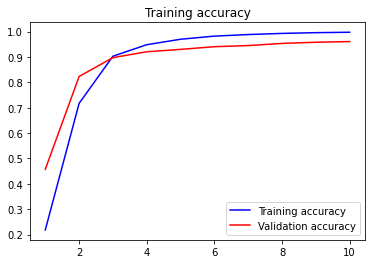

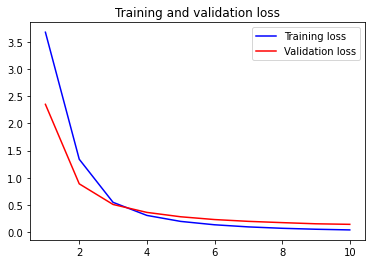

In [13]:
acc = mobile_ft_history.history['accuracy']
val_acc = mobile_ft_history.history['val_accuracy']
loss = mobile_ft_history.history['loss']
val_loss = mobile_ft_history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()
plt.savefig('D:/TQ/Fruits360/Results/MobileNet_FineTuned_2_Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('D:/TQ/Fruits360/Results/MobileNet_FineTuned_2_Loss.jpg')

In [14]:
# Confusion Matrix
start = datetime.datetime.now()
Y_pred = mobile_preds_ft
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testgen.classes, y_pred)
print(cm)

end= datetime.datetime.now()
print("Testing End at: ", end)
elapsed= end-start
print ("Time: ", elapsed)

[[151   0   0 ...   0   0   0]
 [  0 145   0 ...   0   0   0]
 [  0   0 118 ...   0   0   6]
 ...
 [  0   0   0 ... 157   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]
Testing End at:  2022-07-26 20:42:02.173666
Time:  0:00:00.011947


In [15]:
report = classification_report(testgen.classes, y_pred, target_names=total_classes)
print(report)

                     precision    recall  f1-score   support

     Apple Braeburn       0.79      0.92      0.85       164
 Apple Crimson Snow       0.98      0.98      0.98       148
     Apple Golden 1       0.90      0.74      0.81       160
     Apple Golden 2       0.83      0.88      0.85       164
     Apple Golden 3       0.76      1.00      0.86       161
 Apple Granny Smith       0.99      0.92      0.95       164
    Apple Pink Lady       0.78      0.87      0.82       152
        Apple Red 1       0.83      0.77      0.80       164
        Apple Red 2       0.84      0.79      0.81       164
        Apple Red 3       0.99      0.92      0.95       144
Apple Red Delicious       0.99      0.95      0.97       166
 Apple Red Yellow 1       0.95      0.96      0.95       164
 Apple Red Yellow 2       0.97      0.89      0.93       219
            Apricot       0.99      0.96      0.98       164
            Avocado       1.00      0.99      1.00       143
       Avocado ripe    

In [16]:
file_names=testgen.filenames  # save list of test files names to be used later
tlabels=testgen.labels # save test labels to be used later
class_dict=testgen.class_indices
# code below determines test batch size and test steps
# so you go through the test images exactly once
length=len(file_names) # determine number of images
b_max=80 # set maximum batch size you will allow
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=b_max],reverse=True)[0]
test_steps=int(length/BATCH_SIZE)
# make predictions
preds=Y_pred
new_dict={} 
for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key
error_list=[] # empty list to store if the prediction was correct or not
true_predictions = {}
false_predictions = {}
error_file_list=[]
a = b = 1
for i, p in enumerate(preds):
    pred_index=np.argmax(p) # get the index that has the highest probability
    if pred_index == tlabels[i]: #correct predictions
      true_predictions[a] = {}
      true_predictions[a]['PredictedClass'] = new_dict[pred_index]
      true_predictions[a]['TrueClass'] = new_dict[tlabels[i]]
      true_predictions[a]['FileName'] = file_names[i]
      true_predictions[a]['Status'] = 'No'
      error_list.append('No')
      a+=1
    else:
      error_list.append('Yes')
      false_predictions[b] = {}
      false_predictions[b]['PredictedClass'] = new_dict[pred_index]
      false_predictions[b]['TrueClass'] = new_dict[tlabels[i]]
      false_predictions[b]['FileName'] = file_names[i]
      false_predictions[b]['Status'] = 'Yes'
      b+=1
      #print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {error_status:10s}')  
      
print("Total Images: ",len(error_list))
print("True Predictions: ",len(true_predictions))
print("False Predictions: ",len(false_predictions))

Total Images:  22688
True Predictions:  20929
False Predictions:  1759


In [17]:
print("---------------------True Predictions--------------------\n")
print('PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS' ) # adjust spacing based on your class names
for i in range(1,1150):
  pred_class = true_predictions[i]['PredictedClass']  # find the predicted class based on the index
  true_class = true_predictions[i]['TrueClass'] # use the test label to get the true class of the test file
  file = true_predictions[i]['FileName']
  status = true_predictions[i]['Status']
  print(f'    {pred_class:10s}       {true_class:10s}    {file:25s}   {status:10s}') 

---------------------True Predictions--------------------

PREDICTED CLASS            TRUE CLASS         FILENAME                        STATUS
    Apple Braeburn       Apple Braeburn    Apple Braeburn\321_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\322_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\323_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\324_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\325_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\326_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\327_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\32_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\33_100.jpg   No        
    Apple Braeburn       Apple Braeburn    Apple Braeburn\34_100.jpg   No        
    Apple Braeburn       Appl